# **Week 4: Lab Exercises for COMP499/691 Conversational AI**

This project aims to create a task-oriented, multi-turn dialogue system using the popular Ubuntu Dialogue Corpus. The corpus contains dialogues from an ubuntu support chat.

## **Task Description**

Next Utterance Classification (NUC) is a task whose objective is to have the model attempt to distinguish between valid and invalid responses based on the context of a given conversation. 





**Run the code below** to download the Ubuntu Dialogue Corpus data.

In [1]:
import csv
from nltk import download, word_tokenize
from gensim.models import Word2Vec
import pandas as pd

download('punkt', quiet=True)

DATA_FOLDER='./src'
TRAIN_FILE='train_large.csv'
VALID_FILE='valid.csv'
TEST_FILE='test.csv'

In [ ]:
# Update gdown for the latest version
!pip install --upgrade --no-cache-dir gdown

!gdown 1UNaMsyhqzYYe5jOQH0p7QI99_WTil2rW

Once downloaded, we can follow it up by uncompress the data. **Run the code below** to unzip the downloaded file.

In [ ]:
%%capture
!unzip UDC.zip -d raw

The dataset is split into training, validation, and test data as you can see by opening `train.csv`, `valid.csv`, and `test.csv`.

The data is formatted differently for the training data than it is for the validation and test data. 

The train data is separated into 3 columns: the context of the conversation (`Context`), the candidate response (`Utterance`), and a flag (`Label`) denoting whether the response is a 'true response' to the context (flag = 1), or a randomly drawn response from elsewhere in the dataset (flag = 0).

The validation and test data contain 11 columns. The row represents a question. Separated into 11 columns: the context (`Context`), the true response to the context (`Ground Truth Utterance`), and 9 false responses (`Distractors`) that were randomly sampled from elsewhere in the dataset. The model gets a question correct if it selects the ground truth utterance from amongst the 10 possible responses.

There are 1 000 000 sentences for training, 19 560 for validation, and 18 920 for testing.

## **Step 0. Creating Word Embeddings**

**Run the code below** to create the word embeddings needed for training our models

In [ ]:
train = pd.read_csv('./raw/%s' % TRAIN_FILE)
train['Combined'] = train['Context'] + ' ' + train['Utterance']
path = './src/train_large_preprocessed.csv'
train.to_csv(path, columns=['Combined'], sep='ű', escapechar='`', header=False, index=False, quoting=csv.QUOTE_NONE)

# This is attempt number 2. It requires a lot of RAM to run, and ~5 minutes to fully complete
# train['Tokenized'] = train.apply(lambda row: word_tokenize(row['Context'] + ' ' + row['Utterance']), axis=1)
# train['Tokenized'].memory_usage()


In [ ]:
# Parameters to train the word2vec model
embedding_size = 300
window_size=7
min_count=1
workers=3

# Word2Vec Model Training. Takes around ~6 mins to complete
model = Word2Vec(
  vector_size=embedding_size,
  window=window_size,
  min_count=min_count,
  workers=workers
)
print('Building vocabulary...')
model.build_vocab(corpus_file='./src/train_preprocessed.csv', keep_raw_vocab=False)

print('Training the model...')
model.train(corpus_file='./src/train_preprocessed.csv', total_words=90959873, total_examples=1000000, epochs=model.epochs)

print('Done!')



**Run the code below** to save the word2vec model as a file for later use by Speechbrain

In [ ]:
# The model will save the following files: word2vec.model, word2vec.model.syn1neg.npy and word2vec.model.wv.vectors.npy
model.save('./src/models/word2vec.model')

# Step 1: Preparing the data

Speechbrain expects the data in a particular standard, so it is important for us to make sure that we can give it as such. we will rework our train file in order for it to be accepted by Speechbrain's Dynamic Item Processing pipeline.

**Run the code below** to load the dataframe to the train file, and add a numbered ID column to the whole dataset.

In [ ]:
# TODO: Data Cleaning
def generate_id(s):
    return abs(hash(s)) % (10 ** 10)


# - Remove variables (ex: $DEITY, $PLAN)
for dataset in [TRAIN_FILE, VALID_FILE, TEST_FILE]:

  df = pd.read_csv('%s/%s' % (DATA_FOLDER, dataset)) 
  # Remove $ characters
  df.replace('\$','',inplace=True, regex=True)
  df['ID'] = 'utt' + df.index.map(str)
  df.set_index('ID', inplace=True)
  df.to_csv('%s/data/%s' % (DATA_FOLDER, dataset), index_label='ID')



## **Approach 1: LSTM-based encoder-decoder architecture with attention**

We will start with a simple RNN-based encoder-decoder architecture, that only considers the response without looking at the dialogue context.



**Run the code below** to install speechbrain.

In [ ]:
%%capture
!pip install speechbrain

You wrote the following yaml file that declares all the components that we need.

**Run the code below** to save the hyperparameter file. Please, revise it carefully to start familiarizing yourself with this format.

In [2]:
%%file LSTM_Single_Encoder.yaml

# ############################################################################
# Model: E2E with attention-based Machine Translation
# Encoder: LSTM
# Decoder: LSTM
# Tokens: Words
# losses: BCE
# Training: UDC
##############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 1337
__set_seed: !apply:torch.manual_seed [!ref <seed>]
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')
# weights = torch.FloatTensor(model.vectors)
# Folder set up

data_folder: !PLACEHOLDER


output_folder: !ref results/LSTM_Single_Encoder/<seed>
wer_file: !ref <output_folder>/wer.txt # NOTE: might not need this, word error rate
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
cer_file: !ref <output_folder>/test_cer.txt # file were to store the final character error rate on the test set. NOTE: might not need that

# Path where data manifest files are stored
train_annotation: !ref <data_folder>/data/train.csv
valid_annotation: !ref <data_folder>/data/valid.csv
test_annotation: !ref <data_folder>/data/test.csv

# Path where the embeddings are stored
word2vec_file: !ref <data_folder>/models/w2v_raw/word2vec.model
embeddings_file: !ref <data_folder>/models/w2v_raw/word2vec.model.wv.vectors.npy

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
# NOTE: Hyperparams taken from https://github.com/rkadlec/ubuntu-ranking-dataset-creator
number_of_epochs: 100
batch_size: 256
lr: 0.001
lr_final: 0.00005


# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Vocabulary size
voc_size: 1344621 # crazy TODO: May need it if we want to finetune embedding encoder

# Number of flags (good or bad response)
n_classes: 2

# Indexes for begin-of-sentence (bos) 
# and end-of-sentence (eos) # TODO not needed either perhaps
blank_index: 0 # This special token is for padding
bos_index: 1
eos_index: 2


# Encoder Parameters
enc_hidden_size: 300
enc_num_layers: 2 # Not sure about that, start with 1 for now

# Decoder Parameters
dec_hidden_size: 300 # Not sure about that either
dec_num_layers: 3   
attn_dim: 300
dropout: 0.5

# Epoch Counter
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Response Encoder (Good)
response_encoder: !new:speechbrain.nnet.RNN.LSTM
    input_size: !ref <enc_hidden_size>
    hidden_size: !ref <enc_hidden_size>
    num_layers: !ref <enc_num_layers>
    dropout: !ref <dropout>

# NOTE: For the next step we may need to create a second encoder
#       To encode the context as part of the design

# Embeddings 
# Load the word2vec model
w2v_model: !apply:gensim.models.Word2Vec.load [!ref <word2vec_file>]

# Load the numpy file created by word2vec
vectors: !apply:numpy.load [!ref <embeddings_file>]

weights: !new:torch.FloatTensor
    data: !ref <vectors>
    
input_embeddings: !apply:torch.nn.Embedding.from_pretrained [!ref <weights>]
    
# Attention-based RNN decoder - (Okay, this also seems weird)
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <enc_hidden_size>
    input_size: !ref <dec_hidden_size>
    rnn_type: lstm
    attn_type: content
    hidden_size: !ref <dec_hidden_size>
    attn_dim: !ref <attn_dim>
    num_layers: !ref <dec_num_layers>
    dropout: !ref <dropout>

# Embeddings - (Is this needed? Once again, we're not giving values in)
decoder_emb: !new:torch.nn.Embedding
    num_embeddings: !ref <voc_size>
    embedding_dim: !ref <dec_hidden_size>
    padding_idx: !ref <blank_index>

# Linear transformation on the top of the last hidden layer (This makes sense)
# classifier: !new:torch.nn.Sigmoid

classifier: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_hidden_size>
    n_neurons: !ref <n_classes>

# # Final softmax (for log posteriors computation).
# log_softmax: !new:speechbrain.nnet.activations.Softmax
#     apply_log: True


# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    response_encoder: !ref <response_encoder>
    classifier: !ref <classifier>
    input_embeddings: !ref <input_embeddings>
    decoder: !ref <decoder>
    decoder_emb: !ref <response_encoder>
    


# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <response_encoder>
      - !ref <classifier> 
      - !ref <input_embeddings>
      - !ref <decoder>
      - !ref <decoder_emb>
     

# This function manages learning rate annealing over the epochs.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr>
   
# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        counter: !ref <epoch_counter>


Overwriting LSTM_Single_Encoder.yaml


The RNN.yaml hyperparameter file is coupled with the following training script (train.py).

**Complete the code below** to implement the targeted system. You have to write your code in the `forward` and `compute_objective` methods where required. The code should match what is declared in the YAML file. Take this opportunity to further familiarize yourself with the SpeechBrain training script (they are all similar). In particular, try to understand the data flow: take a look at how we create and process entries declared in the CSV files, how we turn the sequence of chars into a sequence of corresponding integers,  how we turn the processed entries into batches, etc.

In [ ]:
%%file train.py

#!/usr/bin/env/python3
"""Recipe for training a sequence-to-sequence machine translation system 
on "ignotush".
The system employs an encoder, a decoder, and an attention mechanism
between them. 

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an GRU encoder and decoder.

The neural network is trained with the negative-log likelihood objective and
characters are used as basic tokens for both english and ignotush.
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from nltk import word_tokenize
from hyperpyyaml import load_hyperpyyaml

logger = logging.getLogger(__name__)


# Brain class for speech recognition training
class UbuntuBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.tensor
            Log-probabilities predicted by the decoder.
            
        At validation/test time, it returns the predicted tokens as well.
        """
        
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device) # todo

        if stage == sb.Stage.TRAIN:
            # Unpack inputs
            utterances, lens = batch.utterance
            # Input embeddings
            embeddings = self.modules.input_embeddings(utterances)
            # Running the encoder
            encoded_signal, _ = self.modules.response_encoder(embeddings)
            # Compute probability using a sigmoid
            predictions = self.modules.classifier(encoded_signal[:,-1,:])
            # Compute softmax
            # predictions = self.hparams.log_softmax(logits)
        elif stage == sb.Stage.VALID:
            # Unpack the context
            context, _ = batch.context 
            context_embeddings = self.modules.input_embeddings(context)
            context_signal, _ = self.modules.response_encoder(context_embeddings)

            probas = []
            for response in [batch.ground_truth_utterance, batch.distractor_0]:
                utt, _ = response
                embeddings = self.modules.input_embeddings(utt)
                encoded_signal, _ = self.modules.response_encoder(embeddings)
                probas.append(self.modules.classifier(encoded_signal[:,-1,:]))
            
            # Unpack the responses
            print([p for p in probas])
            
            # Getting some predictions.
            # Note: For simplicity we use teacher forcing also for testing.
            # For a real inference, you would need to implement greedy search 
            # and feed into the autoregressive model the actual predictions
            # done at each step by the model. 
            hyps = predictions.argmax(-1)
            
            # getting the first index where the prediciton is eos_index
            stop_indexes = (hyps==self.hparams.eos_index).int()
            stop_indexes = stop_indexes.argmax(dim=1)
            
            # Converting hyps from indexes to chars
            hyp_lst = []
            for hyp, stop_ind in zip(hyps, stop_indexes):
                # in some cases the eos in not observed (e.g, for the last sentence
                # in the batch)
                if stop_ind == 0:
                    stop_ind = -1
                # Stopping when eos is observed
                hyp = hyp[0:stop_ind]
                # From index to character
                hyp_lst.append(self.label_encoder.decode_ndim(hyp))

            return predictions, hyp_lst
        
        return predictions
        

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        
        Arguments
        ---------
        predictions : torch.tTensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Unpacking Labels
        targets, _ = batch.label
        
        
        # Reading the predictions
        if stage == sb.Stage.TEST:
          predictions, hyp_lst = predictions
          
          for id, inp, label, hyp in zip(batch.id, batch.ignotush_chars, batch.english_chars, hyp_lst):
              print(id)
              print("INP: " + ''.join(inp))
              print("REF: " + ''.join(label))
              print("HYP: " + ''.join(hyp))
              print('--------')
        
        # Computing the bce_loss
        loss = sb.nnet.losses.bce_loss(predictions, targets)   
        
        return loss

            
    def on_stage_end(self, stage, stage_loss, epoch):
        print("STAGE_END")
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats


        # Perform end-of-iteration things, like annealing, logging, etc.
        elif stage == sb.Stage.VALID:
            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats={
                    "loss": stage_loss,
                },
            )
            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"loss": stage_stats["loss"]}, min_keys=["loss"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats={
                    "loss": stage_loss,
                },
            )
            

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """

    def preprocess_text(text):
        return [hparams['w2v_model'].wv.get_index(t, 0) for t in word_tokenize(text)]

    @sb.utils.data_pipeline.takes("Context", "Utterance", "Label")
    @sb.utils.data_pipeline.provides("context", "utterance", "label")
    def train_text_pipeline(context, utterance, label):
        """Processes the transcriptions to generate proper labels"""
        context = torch.LongTensor(preprocess_text(context))
        yield context
        utterance = torch.LongTensor(preprocess_text(utterance))
        yield utterance
        label = torch.LongTensor([float(label)])
        yield label


    @sb.utils.data_pipeline.takes("Context","Ground Truth Utterance","Distractor_0","Distractor_1","Distractor_2","Distractor_3","Distractor_4","Distractor_5","Distractor_6","Distractor_7","Distractor_8")
    @sb.utils.data_pipeline.provides("context","ground_truth_utterance","distractor_0","distractor_1","distractor_2","distractor_3","distractor_4","distractor_5","distractor_6","distractor_7","distractor_8")
    def test_text_pipeline(context,
        ground_truth_utterance,
        distractor_0,
        distractor_1,
        distractor_2,
        distractor_3,
        distractor_4,
        distractor_5,
        distractor_6,
        distractor_7,
        distractor_8):
        """Processes the transcriptions to generate proper labels"""
        context = torch.LongTensor(preprocess_text(context))
        yield context
        ground_truth_utterance = torch.LongTensor(preprocess_text(ground_truth_utterance))
        yield ground_truth_utterance
        distractor_0 = torch.LongTensor(preprocess_text(distractor_0))
        yield distractor_0
        distractor_1 = torch.LongTensor(preprocess_text(distractor_1))
        yield distractor_1
        distractor_2 = torch.LongTensor(preprocess_text(distractor_2))
        yield distractor_2
        distractor_3 = torch.LongTensor(preprocess_text(distractor_3))
        yield distractor_3
        distractor_4 = torch.LongTensor(preprocess_text(distractor_4))
        yield distractor_4
        distractor_5 = torch.LongTensor(preprocess_text(distractor_5))
        yield distractor_5
        distractor_6 = torch.LongTensor(preprocess_text(distractor_6))
        yield distractor_6
        distractor_7 = torch.LongTensor(preprocess_text(distractor_7))
        yield distractor_7
        distractor_8 = torch.LongTensor(preprocess_text(distractor_8))
        yield distractor_8

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    
    # The label encoder will assign a different integer to each element
    # in the output vocabulary 
    # TODO: This needs to be changes
    input_encoder = sb.dataio.encoder.CTCTextEncoder()
    label_encoder = sb.dataio.encoder.CTCTextEncoder()

    for dataset in data_info:
        # We will focus on the train dataset, because it's different from the train and val
        if dataset == "train":
            datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_csv(
                csv_path=data_info[dataset],
                dynamic_items=[train_text_pipeline],
                output_keys=["context","utterance","label"],
            )
            hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True
            print("done")
        else:
            # TODO Later
            datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_csv(
                csv_path=data_info[dataset],
                dynamic_items=[test_text_pipeline],
                output_keys=[
                    "context",
                    "ground_truth_utterance",
                    "distractor_0",
                    "distractor_1",
                    "distractor_2",
                    "distractor_3",
                    "distractor_4",
                    "distractor_5",
                    "distractor_6",
                    "distractor_7",
                    "distractor_8"
                ],
            )
            hparams[f"{dataset}_dataloader_opts"]["shuffle"] = True
            pass

    return datasets


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    
    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )


    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)

    # Trainer initialization
    ubuntu_brain = UbuntuBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
    
    # Making label encoder accessible (needed to compute the character error rate)
    # translate_brain.label_encoder = label_encoder

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    ubuntu_brain.fit(
        ubuntu_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = ubuntu_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


**Run the code below** to start training. We here use a CPU because the task is pretty fast. It might take 10-15 minutes to train the RNN model.

In [ ]:
!python train.py LSTM_Single_Encoder.yaml --data_folder='./src' --device='cpu' --number_of_epochs=3

At test time, we print both hypotheses and references. If everything works well, you should have learned a very plausible translation from Ingnotush to English:




```
snt136
INP: pojiohtta8tthah94poozattzya7ttm6ttaho7ozpooz
REF: TERESA WAS SIXTEEN AND VAMPA SEVENTEEN
HYP: TERESA WAS SIXTEEN AND VAMPA SEVENTEEN 
--------
snt152
INP: 39ha3ottjipattqp95za9ha6jioppfa8ottxnao7ozafop
REF: HIS HEART ACTION IS PRETTY WEAK EVEN YET
HYP: HIS HEART ACTION IS PRETTY WEAK EVEN YET
--------
snt103
INP: 2ooa2ooap3oa1ji52a3566oyaho7ojittklap9moh
REF: GEE GEE THE FROG HOPPED SEVERAL TIMES
HYP: GEE GEE THE FROG HOPPED SEVERAL TIMES
--------
```



Note that some small artifacts in the translation are still possible (e.g., repeating the last character multiple times) because we are using a very simple system. Nevertheless, on average, the quality should be really good. 

Your `train_log.txt` file (see `results/RNN/1986/train_log.txt`) should look like this:



```
epoch: 1, lr: 1.00e-02 - train loss: 3.58 - valid loss: 2.61
epoch: 2, lr: 9.82e-03 - train loss: 2.45 - valid loss: 2.30
epoch: 3, lr: 9.63e-03 - train loss: 2.25 - valid loss: 2.15
epoch: 4, lr: 9.45e-03 - train loss: 2.11 - valid loss: 2.03
epoch: 5, lr: 9.27e-03 - train loss: 1.98 - valid loss: 1.87
epoch: 6, lr: 9.08e-03 - train loss: 1.78 - valid loss: 1.54
epoch: 7, lr: 8.90e-03 - train loss: 1.32 - valid loss: 7.07e-01
epoch: 8, lr: 8.71e-03 - train loss: 6.72e-01 - valid loss: 2.80e-01
epoch: 9, lr: 8.53e-03 - train loss: 3.74e-01 - valid loss: 1.54e-01
epoch: 10, lr: 8.35e-03 - train loss: 2.61e-01 - valid loss: 1.23e-01
epoch: 11, lr: 8.16e-03 - train loss: 2.06e-01 - valid loss: 1.01e-01
epoch: 12, lr: 7.98e-03 - train loss: 1.62e-01 - valid loss: 7.95e-02
epoch: 13, lr: 7.80e-03 - train loss: 1.51e-01 - valid loss: 7.01e-02
epoch: 14, lr: 7.61e-03 - train loss: 1.29e-01 - valid loss: 6.27e-02
epoch: 15, lr: 7.43e-03 - train loss: 1.11e-01 - valid loss: 5.58e-02
epoch: 16, lr: 7.24e-03 - train loss: 1.04e-01 - valid loss: 4.95e-02
epoch: 17, lr: 7.06e-03 - train loss: 9.31e-02 - valid loss: 4.60e-02
epoch: 18, lr: 6.88e-03 - train loss: 7.69e-02 - valid loss: 4.27e-02
epoch: 19, lr: 6.69e-03 - train loss: 7.32e-02 - valid loss: 4.72e-02
epoch: 20, lr: 6.51e-03 - train loss: 7.17e-02 - valid loss: 4.22e-02
epoch: 21, lr: 6.33e-03 - train loss: 6.75e-02 - valid loss: 3.27e-02
epoch: 22, lr: 6.14e-03 - train loss: 6.18e-02 - valid loss: 3.40e-02
epoch: 23, lr: 5.96e-03 - train loss: 5.32e-02 - valid loss: 2.78e-02
epoch: 24, lr: 5.78e-03 - train loss: 4.97e-02 - valid loss: 2.99e-02
epoch: 25, lr: 5.59e-03 - train loss: 4.88e-02 - valid loss: 2.89e-02
epoch: 26, lr: 5.41e-03 - train loss: 5.18e-02 - valid loss: 2.99e-02
epoch: 27, lr: 5.22e-03 - train loss: 4.13e-02 - valid loss: 2.57e-02
epoch: 28, lr: 5.04e-03 - train loss: 3.57e-02 - valid loss: 2.55e-02
epoch: 29, lr: 4.86e-03 - train loss: 3.45e-02 - valid loss: 2.48e-02
epoch: 30, lr: 4.67e-03 - train loss: 3.40e-02 - valid loss: 2.41e-02
epoch: 31, lr: 4.49e-03 - train loss: 2.88e-02 - valid loss: 2.13e-02
epoch: 32, lr: 4.31e-03 - train loss: 3.01e-02 - valid loss: 2.03e-02
epoch: 33, lr: 4.12e-03 - train loss: 3.11e-02 - valid loss: 2.36e-02
epoch: 34, lr: 3.94e-03 - train loss: 2.63e-02 - valid loss: 2.00e-02
epoch: 35, lr: 3.76e-03 - train loss: 2.51e-02 - valid loss: 2.31e-02
epoch: 36, lr: 3.57e-03 - train loss: 2.32e-02 - valid loss: 2.09e-02
epoch: 37, lr: 3.39e-03 - train loss: 2.09e-02 - valid loss: 1.98e-02
epoch: 38, lr: 3.20e-03 - train loss: 1.98e-02 - valid loss: 1.86e-02
epoch: 39, lr: 3.02e-03 - train loss: 1.94e-02 - valid loss: 1.81e-02
epoch: 40, lr: 2.84e-03 - train loss: 1.82e-02 - valid loss: 2.12e-02
epoch: 41, lr: 2.65e-03 - train loss: 1.63e-02 - valid loss: 1.88e-02
epoch: 42, lr: 2.47e-03 - train loss: 1.61e-02 - valid loss: 1.79e-02
epoch: 43, lr: 2.29e-03 - train loss: 1.51e-02 - valid loss: 1.49e-02
epoch: 44, lr: 2.10e-03 - train loss: 1.41e-02 - valid loss: 1.71e-02
epoch: 45, lr: 1.92e-03 - train loss: 1.42e-02 - valid loss: 1.71e-02
epoch: 46, lr: 1.73e-03 - train loss: 1.32e-02 - valid loss: 1.60e-02
epoch: 47, lr: 1.55e-03 - train loss: 1.24e-02 - valid loss: 1.56e-02
epoch: 48, lr: 1.37e-03 - train loss: 1.50e-02 - valid loss: 1.56e-02
epoch: 49, lr: 1.18e-03 - train loss: 1.23e-02 - valid loss: 1.49e-02
epoch: 50, lr: 1.00e-03 - train loss: 1.19e-02 - valid loss: 1.46e-02
Epoch loaded: 50 - test loss: 2.90e-02
```




Note that variations to the performance are expected. The most important thing is to get a good test loss (e.g., < 4.00e-02).

We can now plot the training and validation losses stored in the log file.

**Complete the code below** to plot the training and validation curves.

In [ ]:
import matplotlib.pyplot as plt

def get_losses(log_file):
  """This function takes in input a path of a log-file and outputs the train and
  valid losses in lists of float numbers"""

  # Your code here. Aim for 9-10 lines
  with open(log_file) as f:
    lines = f.readlines()
  train_losses = []
  valid_losses = []
  for l in lines[:-1]:
    vals = l.replace(',','').split()
    train_losses.append(float(vals[7]))
    valid_losses.append(float(vals[-1]))
    
  return train_losses, valid_losses

log_file = 'results/RNN/1986/train_log.txt'
train_losses, valid_losses = get_losses(log_file)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend()
plt.show()


You should get something like this:

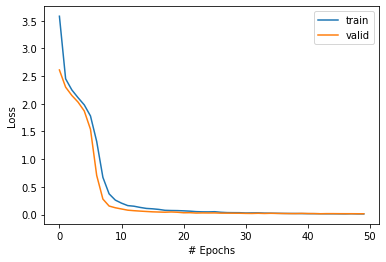